In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
import networkx as nx
import scipy.io as sio

from matplotlib.animation import FuncAnimation

sys.path.insert(0, '../../Libraries')
from ltar import LTAR, diff, invert_diff
from mlds import LMLDS
import JacksonsTSPackage as jts

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

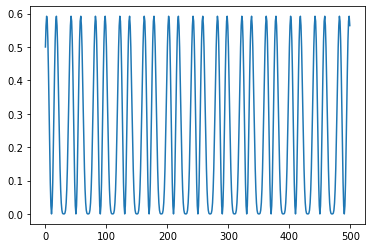

In [2]:
N = 500
n = 1
edge_period = 40
comm_period = 20
tensor = np.zeros((N,n))
for i in range(N):
    for j in range(n):
        tensor[i,j] = ((1+np.cos(i*2*np.pi/comm_period))/2)*((1+np.sin((i*((2*np.pi)/edge_period))+j))/2)
plt.plot(tensor)

In [3]:
def make_sym(A):
    tmp = np.triu(A)
    return tmp + tmp.T

N = 2000
n = 20
edge_period = 40
comm_period = 200
offset = 1
tensor = np.zeros((N,n,n))
num_elem = n*(n-1)//2
xs, ys = np.triu_indices(n, k=1)
shift = np.zeros((n, n))
for i in range(num_elem):
    shift[xs[i],ys[i]] = -i*offset
for i in range(N):
    tmp = (1+np.sin(i*((2*np.pi)/edge_period) + shift))/2 # Does the edge shift
    tmp[:n//2,n//2:] *= (1+np.cos(i*((2*np.pi)/comm_period)))/2
    tmp += np.random.normal(loc=0, scale=0.08, size=(n, n))
    tmp = np.triu(tmp,k=1)
    tmp = tmp + tmp.T
    np.fill_diagonal(tmp, 0)
    tensor[i] = tmp
np.savetxt(f"comm_graph{n}.csv", tensor.reshape((N, n**2)), delimiter=",")

In [19]:
tmp = np.triu(shift,k=1)
tmp = tmp + tmp.T
print(tmp)

[[   0.    0.   -1.   -2.   -3.   -4.   -5.   -6.   -7.   -8.   -9.  -10.
   -11.  -12.  -13.  -14.  -15.  -16.  -17.  -18.]
 [   0.    0.  -19.  -20.  -21.  -22.  -23.  -24.  -25.  -26.  -27.  -28.
   -29.  -30.  -31.  -32.  -33.  -34.  -35.  -36.]
 [  -1.  -19.    0.  -37.  -38.  -39.  -40.  -41.  -42.  -43.  -44.  -45.
   -46.  -47.  -48.  -49.  -50.  -51.  -52.  -53.]
 [  -2.  -20.  -37.    0.  -54.  -55.  -56.  -57.  -58.  -59.  -60.  -61.
   -62.  -63.  -64.  -65.  -66.  -67.  -68.  -69.]
 [  -3.  -21.  -38.  -54.    0.  -70.  -71.  -72.  -73.  -74.  -75.  -76.
   -77.  -78.  -79.  -80.  -81.  -82.  -83.  -84.]
 [  -4.  -22.  -39.  -55.  -70.    0.  -85.  -86.  -87.  -88.  -89.  -90.
   -91.  -92.  -93.  -94.  -95.  -96.  -97.  -98.]
 [  -5.  -23.  -40.  -56.  -71.  -85.    0.  -99. -100. -101. -102. -103.
  -104. -105. -106. -107. -108. -109. -110. -111.]
 [  -6.  -24.  -41.  -57.  -72.  -86.  -99.    0. -112. -113. -114. -115.
  -116. -117. -118. -119. -120. -121. -122. -123.]


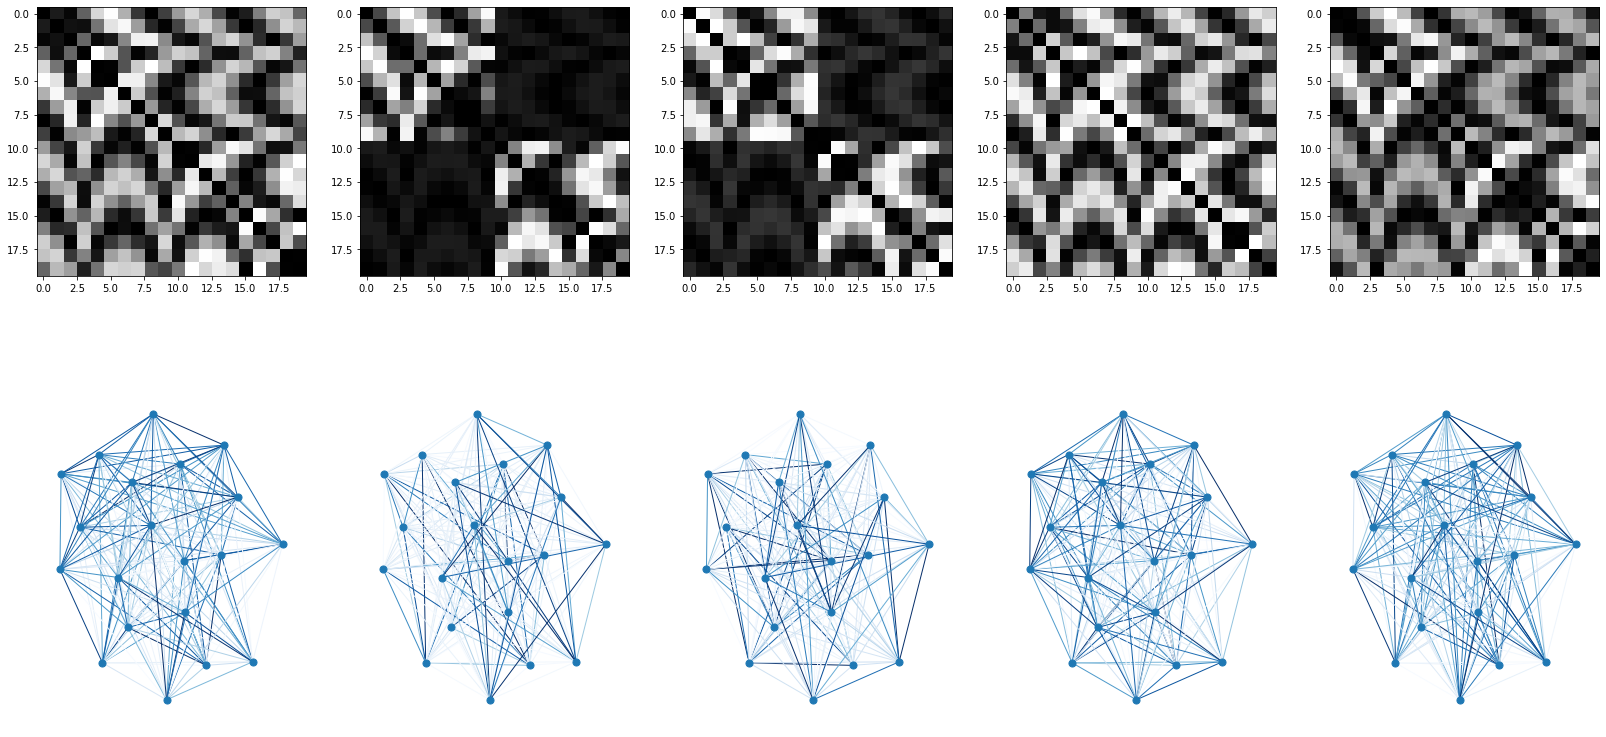

In [20]:
fig, axs = plt.subplots(2, 5, figsize=(28, 14))
pos = nx.spring_layout(nx.from_numpy_matrix(tensor[70]))
for i in range(0, 5):

    curr_i = i*40+20

    axs[0,i].imshow(tensor[curr_i], cmap=plt.get_cmap("gray"), animated = True)
    
    G = nx.from_numpy_matrix(tensor[curr_i])
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    nx.draw(G, node_size=50, with_labels=False, edge_color=weights, edge_cmap=plt.cm.Blues, pos=pos, ax=axs[1,i])

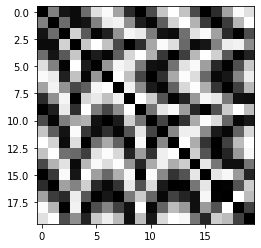

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


<Figure size 432x288 with 0 Axes>

In [24]:
def animate_tensor(tensor, N, save_path):
    global im
    global display_tensor
    display_tensor = tensor
    fig = plt.figure()
    im = plt.imshow(display_tensor[0], cmap=plt.get_cmap("gray"), animated = True)
    ani = FuncAnimation(fig, animate, interval = 100, frames = comm_period, blit=True)
    plt.show()
    ani.save(save_path)

def animate(i):
    global im
    im.set_array(display_tensor[i])
    plt.savefig(f"split/adj-{i}.png")
    return im,

animate_tensor(tensor, comm_period, "adj_mat_comm_noise.gif")

/tmp/ipykernel_306663/4037046710.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [1, 2]}, figsize=(8,2))


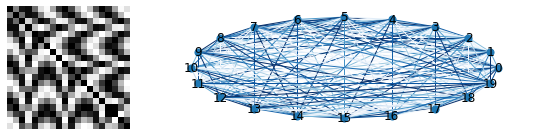

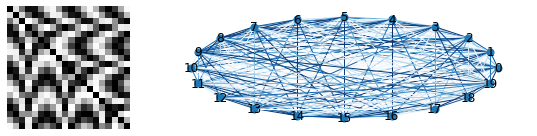

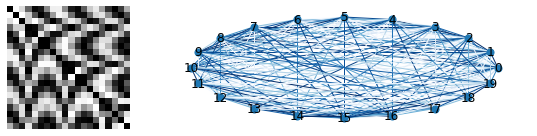

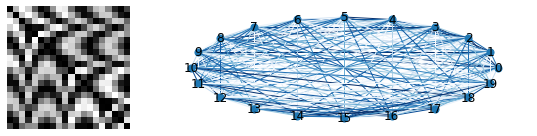

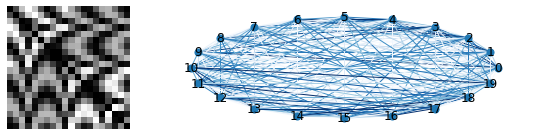

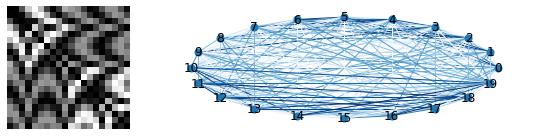

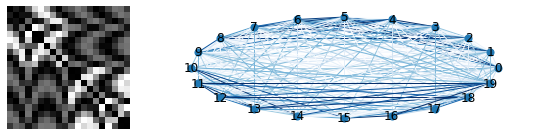

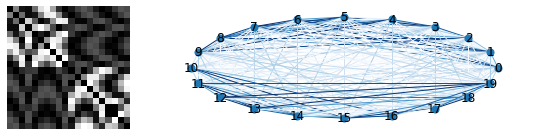

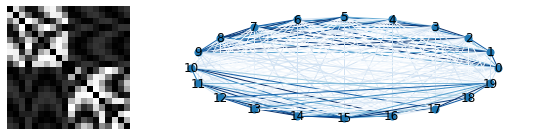

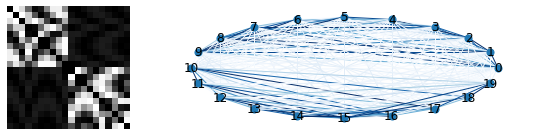

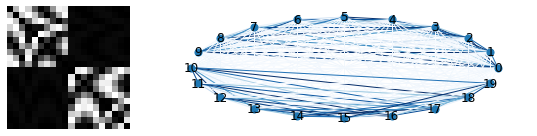

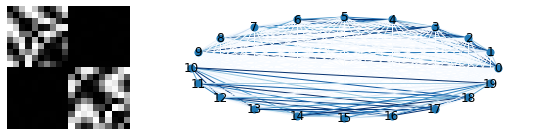

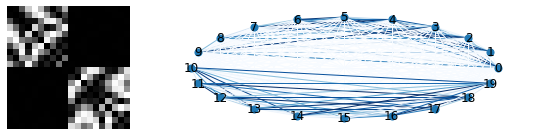

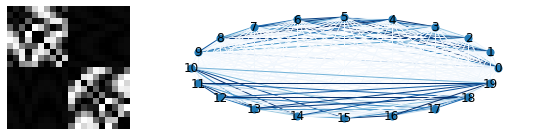

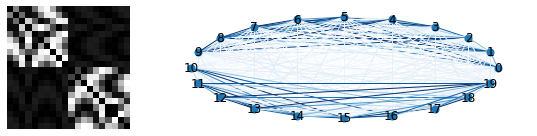

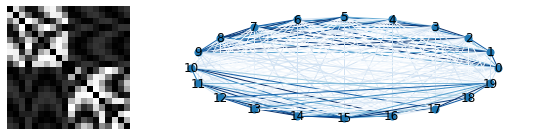

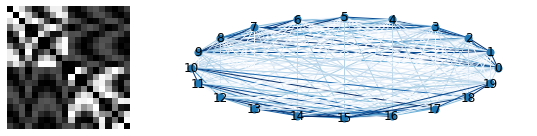

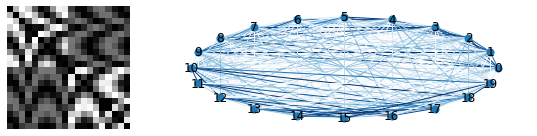

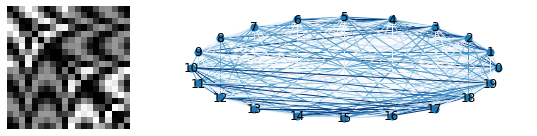

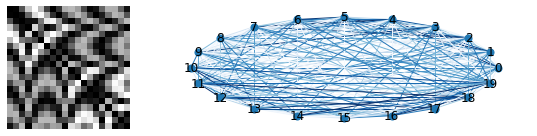

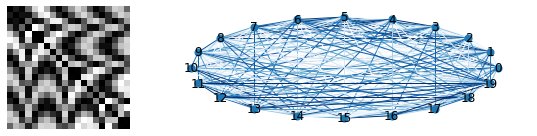

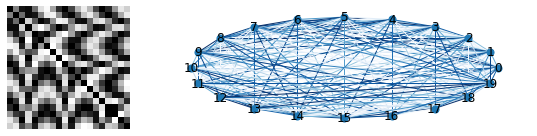

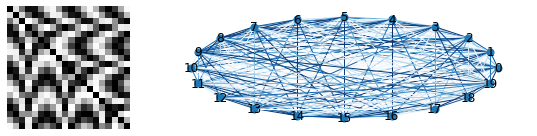

In [47]:
for i in range(comm_period):
    fig, axes = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [1, 2]}, figsize=(8,2))
    axes[0].imshow(display_tensor[i], cmap=plt.get_cmap("gray"))
    axes[0].axis('off')
    curr_G = nx.from_numpy_matrix(tensor[i])
    edges,weights = zip(*nx.get_edge_attributes(curr_G,'weight').items())
    nx.draw(curr_G, node_size=50, with_labels=True, edge_color=weights, edge_cmap=plt.cm.Blues, pos=pos, ax=axes[1]) #, with_labels=True, node_color=color_map
    fig.tight_layout()
    plt.savefig(f"split/graph-{i}.png",bbox_inches='tight')

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


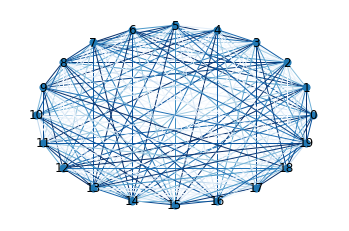

In [28]:
pos = nx.circular_layout(nx.from_numpy_matrix(tensor[100]))
fig, ax = plt.subplots()
def animate(i):
    ax.clear()
    curr_G = nx.from_numpy_matrix(tensor[i])
    edges,weights = zip(*nx.get_edge_attributes(curr_G,'weight').items())
    nx.draw(curr_G, node_size=50, with_labels=True, edge_color=weights, edge_cmap=plt.cm.Blues, pos=pos) #, with_labels=True, node_color=color_map
    plt.savefig(f"split/graph-{i}.png",bbox_inches='tight')
ani = FuncAnimation(fig, animate, frames = comm_period, interval=100)
ani.save("graph_comm.gif")

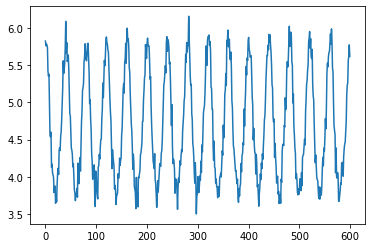

In [22]:
xlim = 600
plot_tensor = tensor[:xlim]
norm = np.array([la.norm(adj) for adj in plot_tensor])
plt.plot(np.arange(len(plot_tensor)), norm)

In [8]:
Ntrain = 1800
Ntest = N - Ntrain
print("Ntrain =", Ntrain)
print("Ntest =", Ntest)

Ntrain = 1800
Ntest = 200


In [9]:
train = tensor[:Ntrain]
test = tensor[Ntrain:N]
print("Train shape =", train.shape)
print("Test shape =", test.shape)

Train shape = (1800, 20, 20)
Test shape = (200, 20, 20)


In [10]:
diff_tensor = diff(tensor, 200)
ltar = LTAR(diff_tensor[:Ntrain-200])
ltar.fit(40)
forecast = invert_diff(ltar.forecast(Ntest), train[-200:], 200)

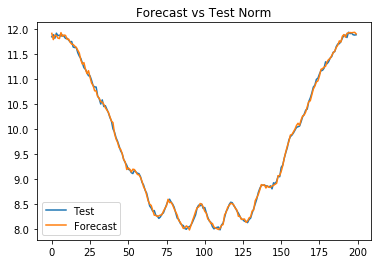

In [11]:
forecast_norm = np.array([la.norm(adj) for adj in forecast])
test_norm = np.array([la.norm(adj) for adj in test])
plt.plot(test_norm)
plt.plot(forecast_norm)
plt.title("Forecast vs Test Norm")
plt.legend(["Test","Forecast"])

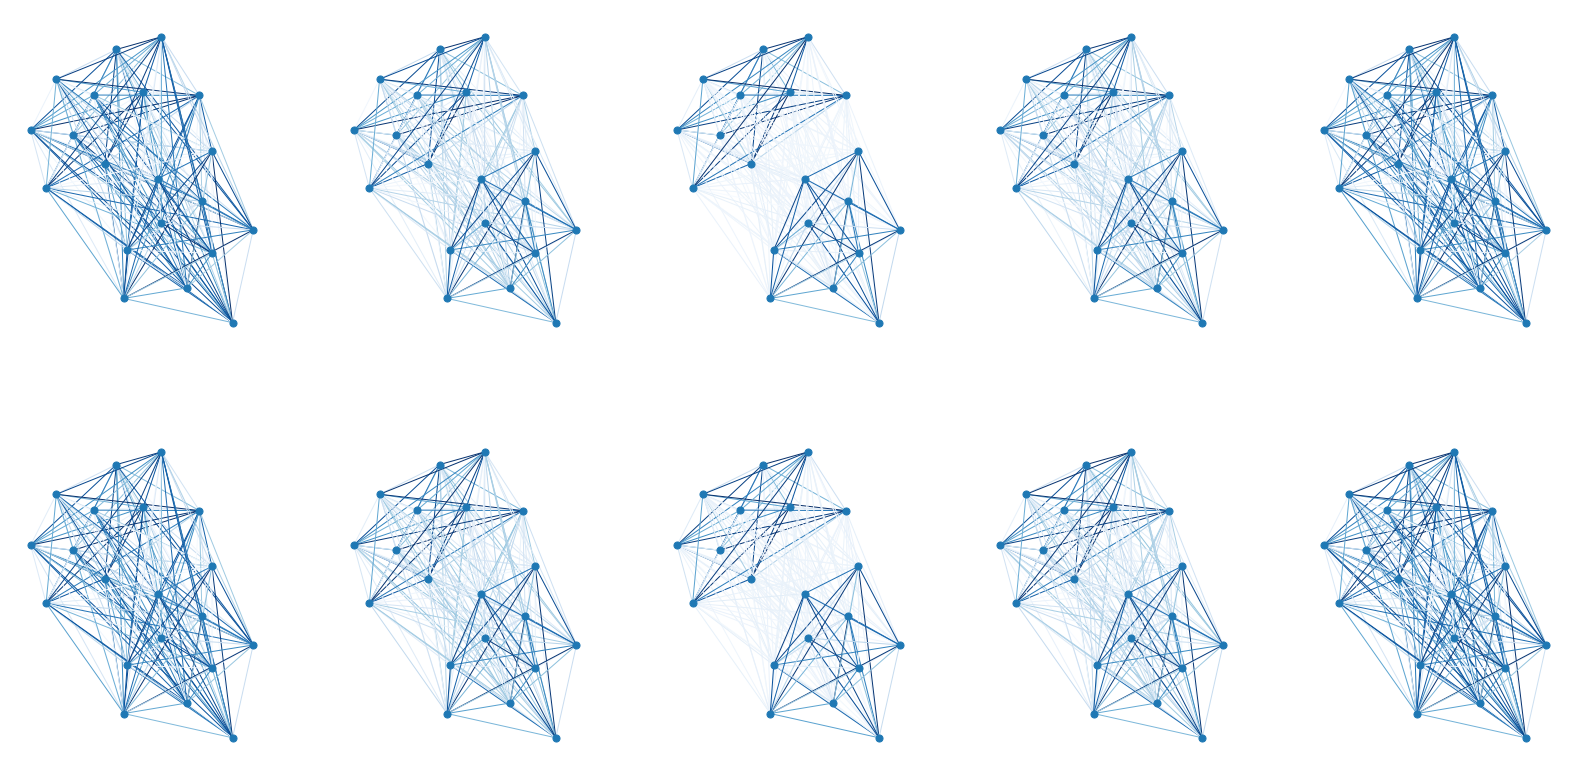

In [50]:
fig, axs = plt.subplots(2, 5, figsize=(28, 14))
for i in range(0, 5):
    
    test_G = nx.from_numpy_matrix(test[i*40+20])
    edges,weights = zip(*nx.get_edge_attributes(test_G,'weight').items())
    nx.draw(test_G, node_size=50, with_labels=False, edge_color=weights, edge_cmap=plt.cm.Blues, pos=pos, ax=axs[1,i])

    np.fill_diagonal(forecast[i*40+20], 0)
    fore_G = nx.from_numpy_matrix(forecast[i*40+20])
    edges,weights = zip(*nx.get_edge_attributes(fore_G,'weight').items())
    nx.draw(fore_G, node_size=50, with_labels=False, edge_color=weights, edge_cmap=plt.cm.Blues, pos=pos, ax=axs[0,i])

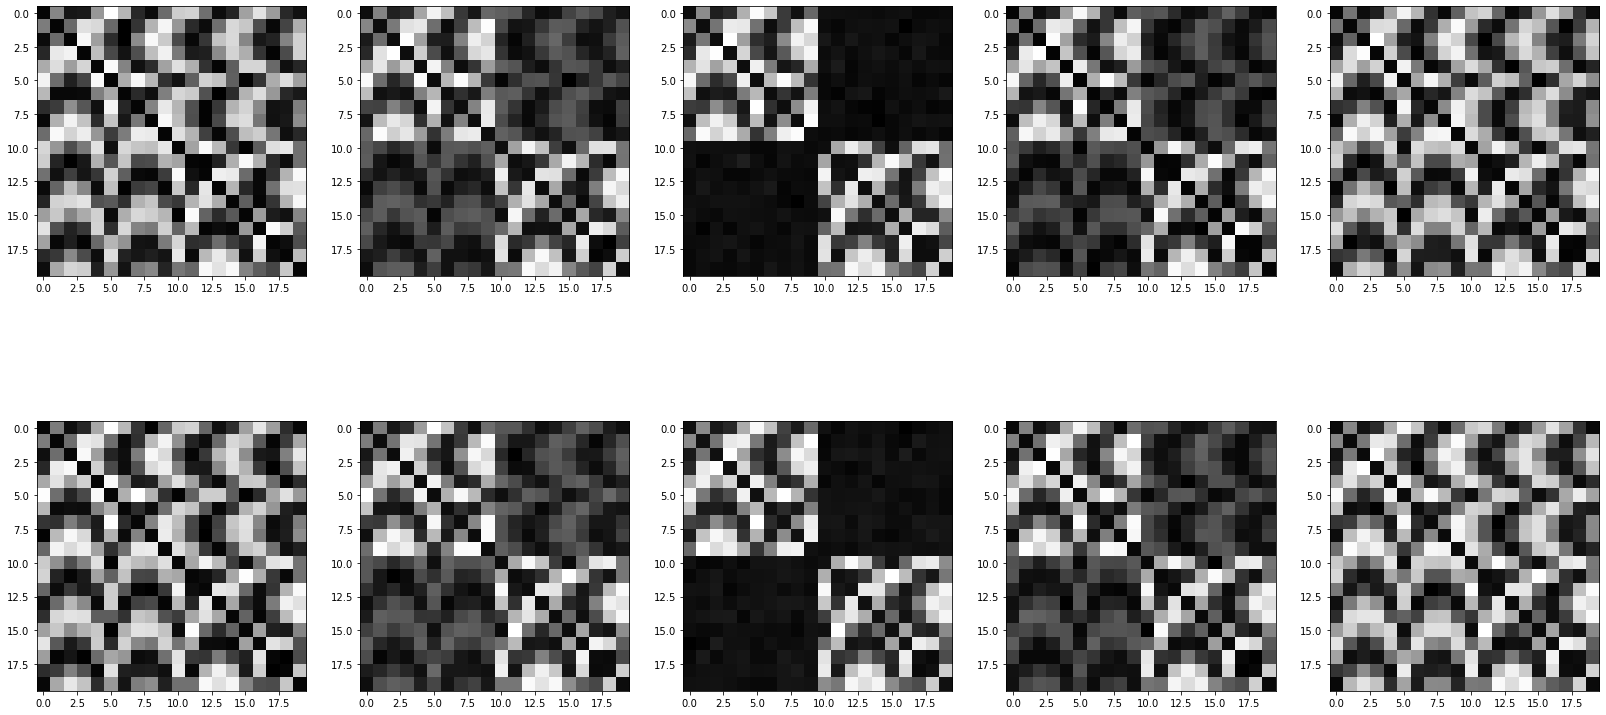

In [52]:
fig, axs = plt.subplots(2, 5, figsize=(28, 14))
for i in range(0, 5):
    
    axs[0,i].imshow(forecast[i*40+20], cmap=plt.get_cmap("gray"), animated = True)
    axs[1,i].imshow(test[i*40+20], cmap=plt.get_cmap("gray"), animated = True)

In [42]:
# plt.figure(figsize=(14,20))
# for i in range(5, 15):
#     plt.subplot(10,1,i+1-5)
#     plt.plot(forecast[:,0,i])
#     plt.plot(test[:,0,i])

Text(0.5, 1.0, 'APE over time')

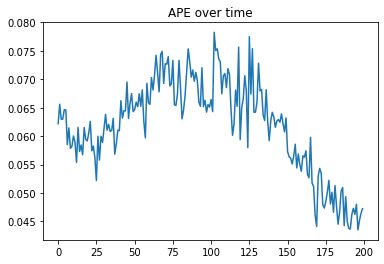

In [43]:
error = jts.calc_mape_per_matrix(test, forecast)
plt.plot(error)
plt.title("APE over time")

Text(0.5, 1.0, 'SE over time')

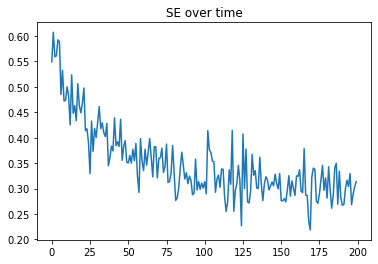

In [44]:
serror = jts.calc_mase_per_matrix(test, forecast)
plt.plot(serror)
plt.title("SE over time")

(-1, 1)

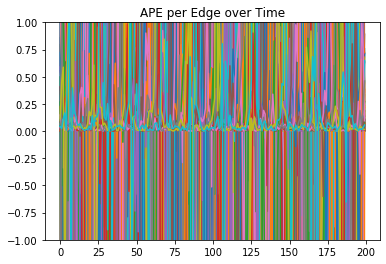

In [45]:
error_edge = np.zeros((Ntest, num_elem))
for i in range(Ntest):
    for j in range(num_elem):
        curr_test_node = test[i][xs[j],ys[j]]
        curr_forecast_node = forecast[i][xs[j],ys[j]]
        error_edge[i][j] = np.abs(curr_test_node - curr_forecast_node) / curr_test_node
plt.plot(error_edge)
plt.title("APE per Edge over Time")
plt.ylim(-1,1)

Text(0.5, 1.0, 'Avg % Error over Time')

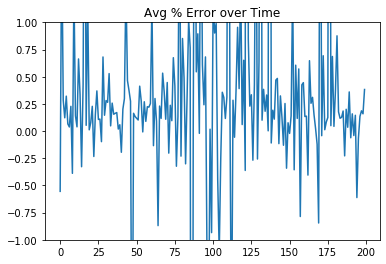

In [46]:
plt.plot(np.average(error_edge, axis=1))
plt.ylim(-1,1)
plt.title("Avg % Error over Time")

In [47]:
def animate_tensor(tensor, N, save_path):
    global im
    global display_tensor
    display_tensor = tensor
    fig = plt.figure()
    im = plt.imshow(display_tensor[0], cmap=plt.get_cmap("gray"), animated = True)
    ani = FuncAnimation(fig, animate, interval = 100, frames = N, blit=True)
    plt.show()
    ani.save(save_path)

def animate(i):
    global im
    im.set_array(display_tensor[i])
    return im,
#animate_tensor(test, Ntest, "adj_mat_comm_test.gif")
#animate_tensor(forecast, Ntest, "adj_mat_comm_forecast.gif")

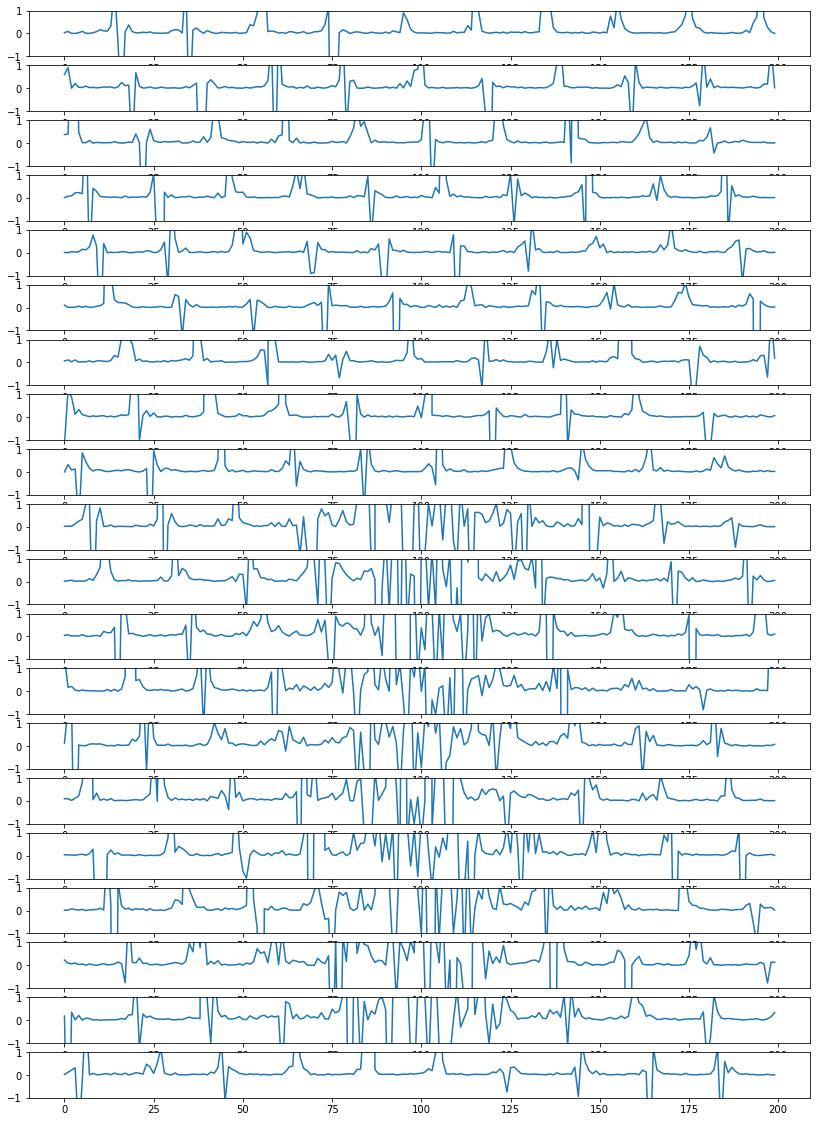

In [48]:
plt.figure(figsize=(14,20))
for i in range(0, 20):
    plt.subplot(20,1,i+1)
    plt.plot(error_edge[:,i])
    plt.ylim(-1,1)

In [49]:
error_edge.shape

(200, 190)

In [51]:
lmlds = LMLDS(train)
lmlds.fit()
lmlds_forecast = lmlds.forecast(Ntest)

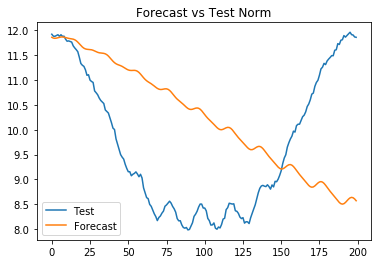

In [52]:
lmlds_forecast_norm = np.array([la.norm(adj) for adj in lmlds_forecast])
plt.plot(test_norm)
plt.plot(lmlds_forecast_norm)
plt.title("Forecast vs Test Norm")
plt.legend(["Test","Forecast"])

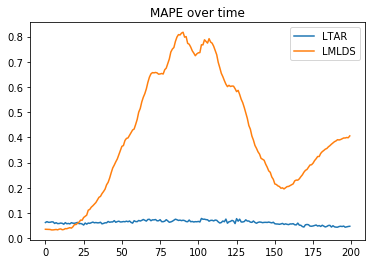

In [53]:
lmlds_error = jts.calc_mape_per_matrix(test, lmlds_forecast)
plt.plot(error)
plt.plot(lmlds_error)
plt.title("MAPE over time")
plt.legend(["LTAR", "LMLDS"])

In [54]:
n_features = 20*20
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        start_ix = i - n_steps
        # check if we are beyond the sequence
        if start_ix >= 0:
            # gather input and output parts of the pattern
            seq_x, seq_y = sequence[start_ix:i], sequence[i]
            X.append(seq_x)
            y.append(seq_y)
    return np.asarray(X), np.asarray(y)
n_steps = 40
sequence = tensor.reshape((N, 400))
X, y = split_sequence(sequence, n_steps)
train_X = X[:Ntrain-n_steps]
train_y = y[:Ntrain-n_steps]
test_X = X[Ntrain-n_steps:N-n_steps]
test_y = y[Ntrain-n_steps:N-n_steps]
lstm = Sequential()
lstm.add(LSTM(500, activation='relu',return_sequences=True, input_shape=(n_steps, n_features)))
lstm.add(LSTM(500, activation='relu'))
lstm.add(Dense(n_features))
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(train_X, train_y, epochs=50, verbose=1)

Epoch 1/50
55/55 [==============================] - 15s 248ms/step - loss: 0.0934
Epoch 2/50
55/55 [==============================] - 14s 248ms/step - loss: 0.0032
Epoch 3/50
55/55 [==============================] - 14s 250ms/step - loss: 8.7896e-04
Epoch 4/50
55/55 [==============================] - 14s 248ms/step - loss: 6.7335e-04
Epoch 5/50
55/55 [==============================] - 14s 248ms/step - loss: 5.5035e-04
Epoch 6/50
55/55 [==============================] - 14s 247ms/step - loss: 5.6160e-04
Epoch 7/50
55/55 [==============================] - 14s 246ms/step - loss: 5.9723e-04
Epoch 8/50
55/55 [==============================] - 14s 248ms/step - loss: 4.8807e-04
Epoch 9/50
55/55 [==============================] - 14s 250ms/step - loss: 4.7791e-04
Epoch 10/50
55/55 [==============================] - 14s 249ms/step - loss: 4.9676e-04
Epoch 11/50
55/55 [==============================] - 14s 249ms/step - loss: 6.2714e-04
Epoch 12/50
55/55 [==============================] - 14s 247

In [58]:
shape = tensor.shape
# yhat = lstm.predict(test_X, verbose=0)
# lstm_forecast = yhat.reshape((Ntest, shape[1], shape[2]))
lstm_forecast = np.zeros((Ntest, shape[1], shape[2]))
lstm_forecast[:n_steps] = lstm.predict(test_X[:n_steps], verbose=0).reshape((n_steps, shape[1], shape[2]))
for i in range(n_steps, Ntest):
    currX = lstm_forecast[i-n_steps:i].reshape((-1, n_steps, n_features))
    lstm_forecast[i] = lstm.predict(currX, verbose=0).reshape((shape[1], shape[2]))

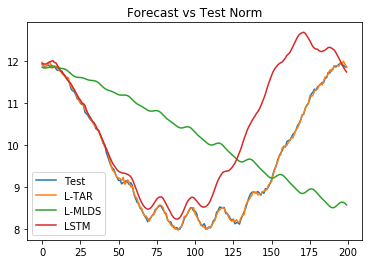

In [59]:
lstm_forecast_norm = np.array([la.norm(adj) for adj in lstm_forecast])
plt.plot(test_norm)
plt.plot(forecast_norm)
plt.plot(lmlds_forecast_norm)
plt.plot(lstm_forecast_norm)
plt.title("Forecast vs Test Norm")
plt.legend(["Test","L-TAR", "L-MLDS", "LSTM"])

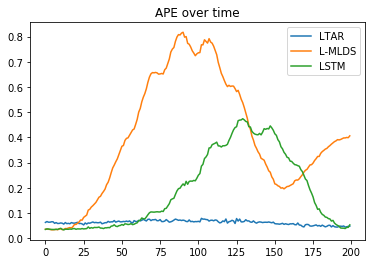

In [60]:
#mlds_err = sio.loadmat('data/sst_err.mat')
lstm_error = jts.calc_mape_per_matrix(test, lstm_forecast)
plt.plot(error)
#plt.plot(mlds_err)
plt.plot(lmlds_error)
plt.plot(lstm_error)
plt.title("APE over time")
plt.legend(["LTAR", "L-MLDS", "LSTM"])